# **Customer Segmentation in Python and visualize the results**

## Import Packages

In [40]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift, SpectralClustering
from sklearn.mixture import GaussianMixture

## Import Dataset

In [41]:
df = pd.read_csv('/content/customer_behavior_analytcis.csv')
df.head()

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts,customer_id
0,7.0,129.34,52.17,18.0,0.0,CM00000
1,22.0,24.18,9.19,15.0,7.0,CM00001
2,2.0,32.18,90.69,50.0,2.0,CM00002
3,25.0,26.85,11.22,16.0,10.0,CM00003
4,7.0,125.45,34.19,30.0,3.0,CM00004


In [44]:
df.set_index('customer_id', inplace=True)
df.head()

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts
customer_id,,,,,
CM00000,7.0,129.34,52.17,18.0,0.0
CM00001,22.0,24.18,9.19,15.0,7.0
CM00002,2.0,32.18,90.69,50.0,2.0
CM00003,25.0,26.85,11.22,16.0,10.0
CM00004,7.0,125.45,34.19,30.0,3.0


## Data Preprocessing

In [27]:
df.shape

(999, 5)

### General Info

In [5]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, CM00000 to CM00998
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   total_purchases   979 non-null    float64
 1   avg_cart_value    979 non-null    float64
 2   total_time_spent  999 non-null    float64
 3   product_click     979 non-null    float64
 4   discount_counts   999 non-null    float64
dtypes: float64(5)
memory usage: 46.8+ KB


In [6]:
df.describe()

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts
count,979.000000,979.000000,999.000000,979.000000,999.000000
mean,11.570991,75.457978,49.348759,28.237998,4.313313
std,7.016327,55.067835,32.730973,16.296384,4.532772
min,0.000000,10.260000,5.120000,4.000000,0.000000
25%,6.000000,33.130000,22.375000,16.000000,1.000000
50%,10.000000,49.380000,40.360000,21.000000,2.000000
75%,17.000000,121.255000,77.170000,45.000000,8.000000
max,32.000000,199.770000,119.820000,73.000000,21.000000


### Handle Missing Values

In [7]:
df.isna().sum()

,0
total_purchases,20
avg_cart_value,20
total_time_spent,0
product_click,20
discount_counts,0


In [8]:
df[df.isna().any(axis=1)]

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts
customer_id,,,,,
CM00097,NaN,NaN,117.04,NaN,0.0
CM00139,NaN,NaN,33.76,NaN,3.0
CM00212,NaN,NaN,42.70,NaN,0.0
CM00253,NaN,NaN,21.28,NaN,12.0
CM00294,NaN,NaN,47.80,NaN,2.0
CM00310,NaN,NaN,82.11,NaN,0.0
CM00317,NaN,NaN,55.19,NaN,0.0
CM00353,NaN,NaN,45.26,NaN,1.0
CM00409,NaN,NaN,22.95,NaN,10.0


* Null values are found in the same set of IDs for all features having null values.

In [42]:
df.dropna(inplace=True)
df.shape

(979, 6)

* All those rows which contains null values are removed.

In [10]:
df.isna().sum()

,0
total_purchases,0
avg_cart_value,0
total_time_spent,0
product_click,0
discount_counts,0


* No more missing values exist in the dataset.

### Find Outliers

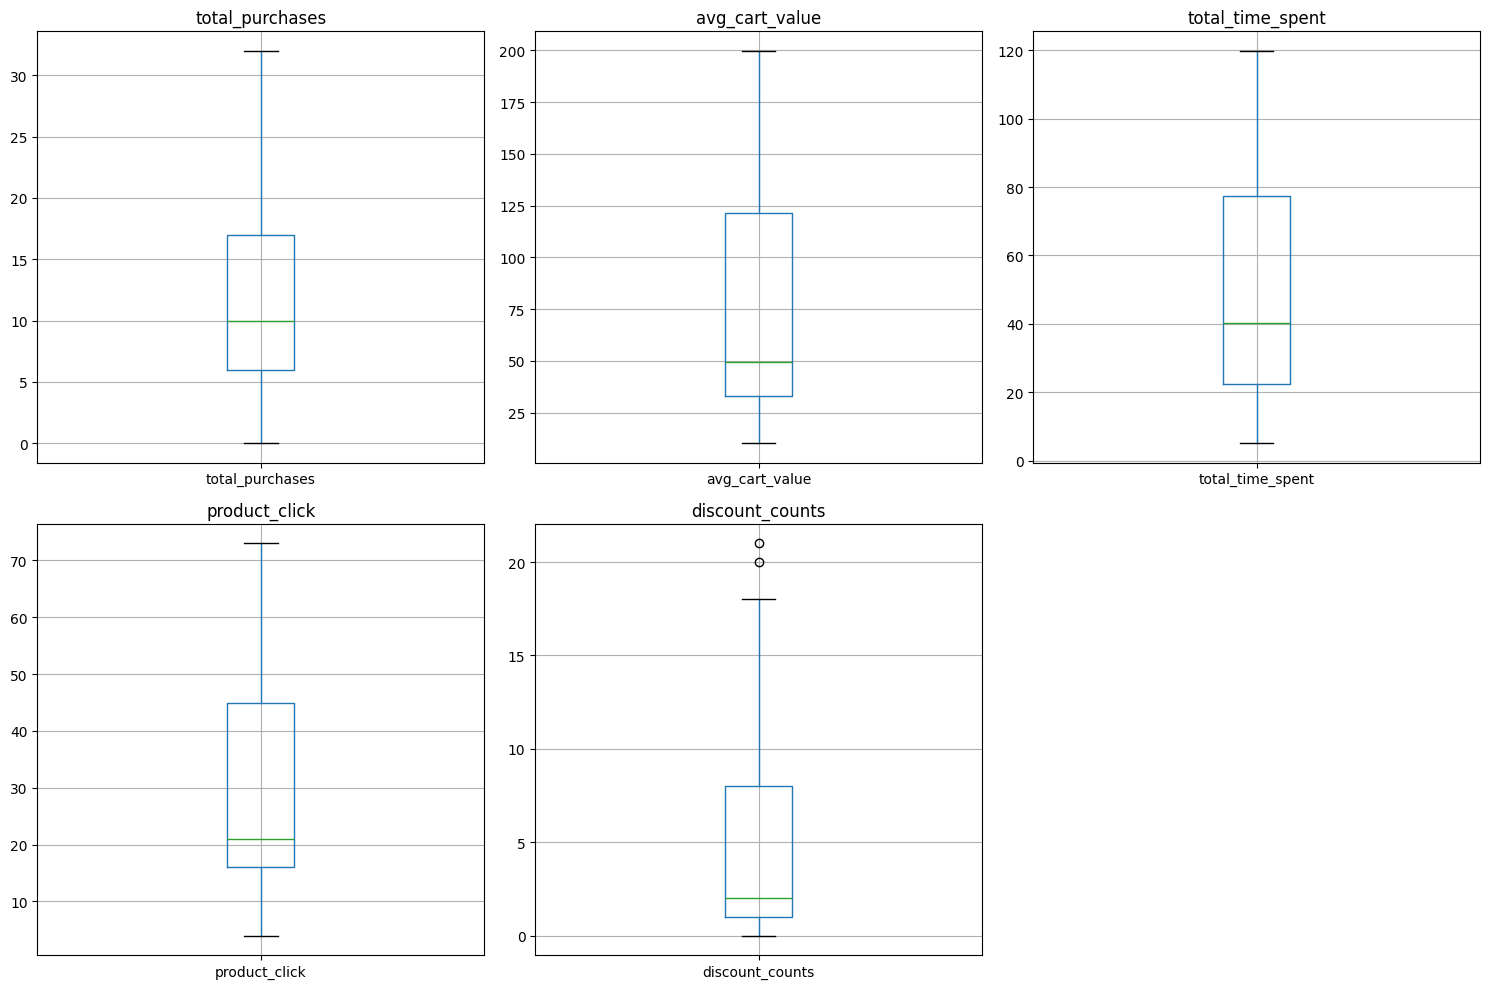

In [11]:
# calculating the number of rows and columns required for creating the subplots
num_columns = df.shape[1]
num_rows = math.ceil(num_columns / 3) # Display 3 boxplots per row

# creating subplots
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

# flattening the axs array (to handle cases where num_columns is not a multiple of 3)
axs = axs.flatten()

# creating boxplots for each numerical column
for i, column in enumerate(df.columns.tolist()):
    ax = axs[i]
    df.boxplot(column=column, ax=ax)
    ax.set_title(column)
    ax.grid(True)

# hiding unused subplots
for j in range(i + 1, len(axs)):
    axs[j].set_visible(False)

# adjusting layout
plt.tight_layout()
plt.show()

* No extreme outliers were observed

## Exploratory Data Analysis (EDA)

### Correlation

In [12]:
# creating a function to create a heat map for correlation matrix
def plot_correlation_heatmap(df):

    # computing the correlation matrix
    corr = df.corr()

    # generating a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # setting up the matplotlib figure
    f, ax = plt.subplots(figsize=(6, 5))

    # generating a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # drawing the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5,
    cbar_kws={"shrink": .5}, annot=True, fmt=".2f",
    annot_kws={"size": 8})

    # viewing plot
    plt.show()

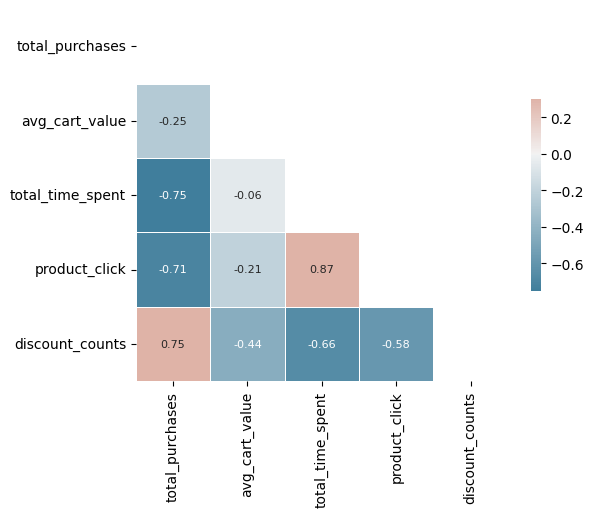

In [13]:
# plotting df_clean
plot_correlation_heatmap(df)

### Distribution Plots

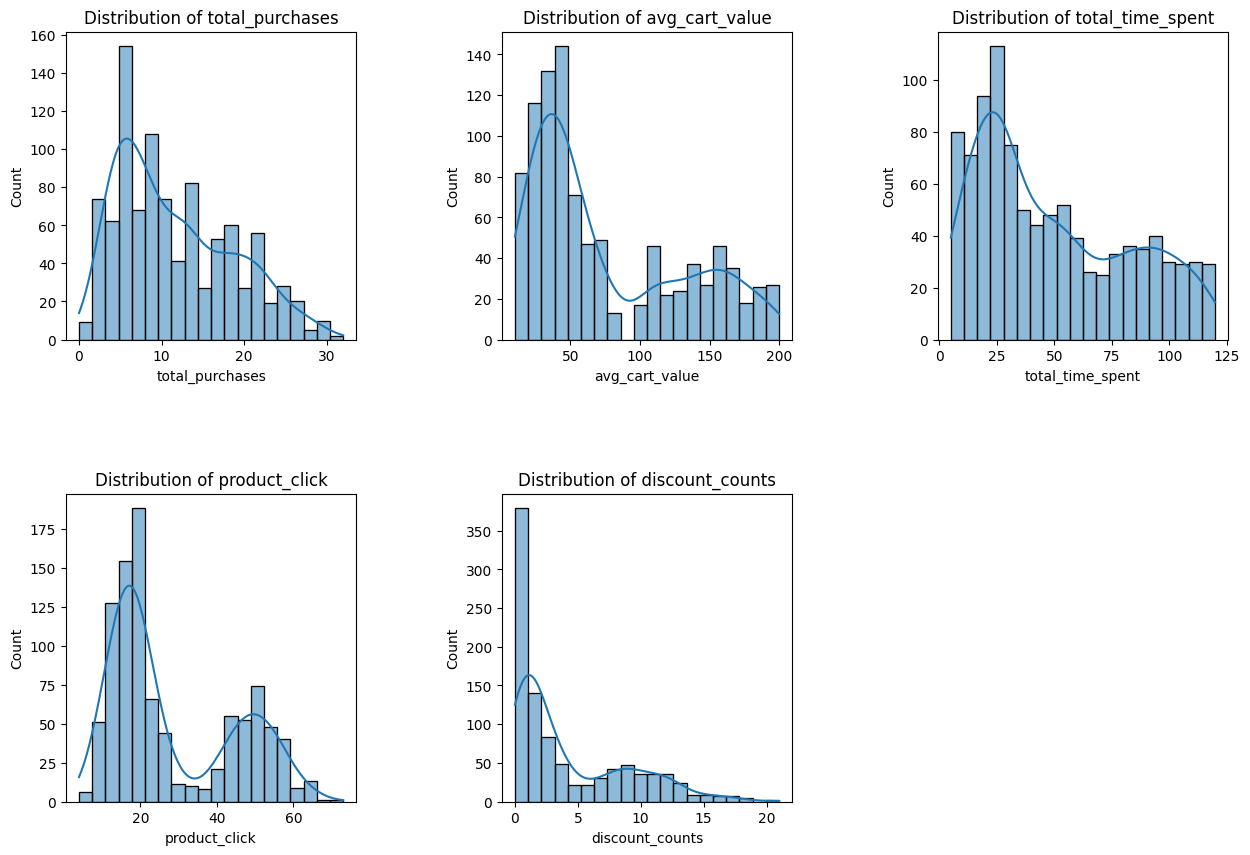

In [ ]:
# extracting numerical columns for distplot
cols_for_dist_plots = df.columns.tolist()

# calculating the number of rows and columns needed for subplots
num_cols = 3 # Set the number of columns per row
num_rows = math.ceil(len(cols_for_dist_plots) / num_cols) # Calculate the number of rows needed

# setting up the subplots
plt.figure(figsize=(15, 5 * num_rows))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# looping through numerical columns to create histograms
for i, column in enumerate(cols_for_dist_plots, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(df, x=column, kde=True, bins=20)
    plt.title(f"Distribution of {column}")

# viewing the plots
plt.show()

### Analysis based on insights given

#### Scatter plots to show clusters

##### 1.   total purchases vs avg cart value



<ipython-input-29-44279236db33>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x="total_purchases", y="avg_cart_value", palette="viridis")


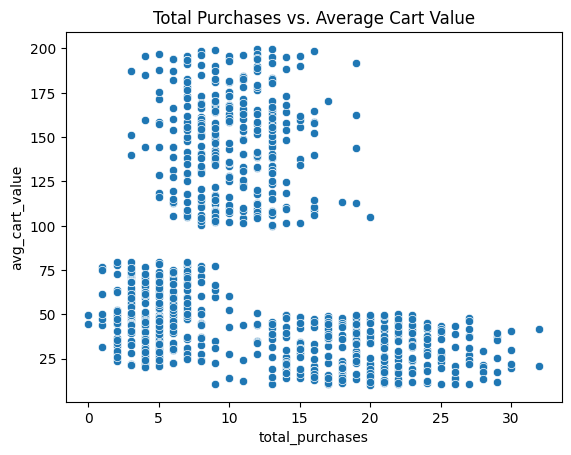

In [29]:
sns.scatterplot(data=df, x="total_purchases", y="avg_cart_value", palette="viridis")
plt.title("Total Purchases vs. Average Cart Value")
plt.show()

* This scatterplot reveals how total purchases relate to average cart value to identify spending patterns

* Observation :

The three clusters may be easily distinguishable here, with Bargain Hunters in the bottom-right corner (high purchases, low cart value), High Spenders in the top-left (moderate purchases, high cart value), and Window Shoppers in the lower part of the plot (low purchases, moderate cart values).

##### 2.   time spent vs product clicks

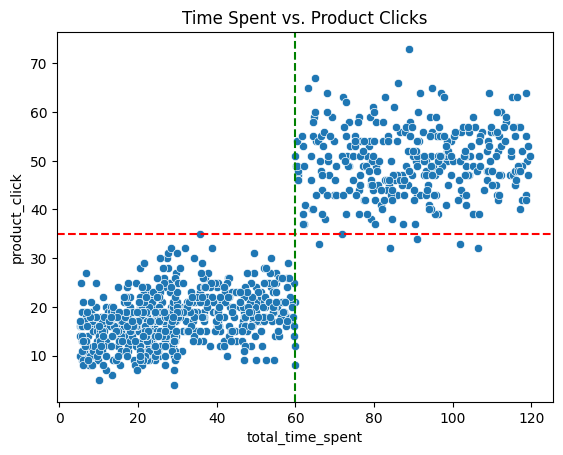

In [23]:
sns.scatterplot(data=df, x="total_time_spent", y="product_click")
# draw a horizontal line at y=35
plt.axhline(35, color='red', linestyle='--')
# draw a vertical line at y=60
plt.axvline(60, color='green', linestyle='--')
plt.title("Time Spent vs. Product Clicks")
plt.show()

* This plot examines the relationship between time spent on the platform and the number of products clicked to visualize browsing behavior.

* Observation :

Window Shoppers have formed a distinct group with high values for both time spent and number of products clicked, while Bargain Hunters and High Spenders have clusters with moderate values for these features.

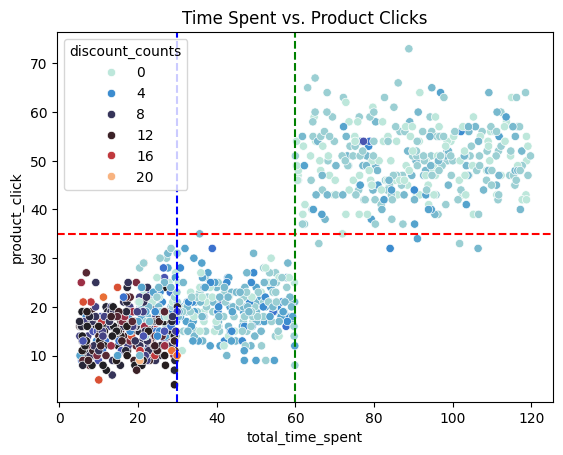

In [21]:
sns.scatterplot(data=df, x="total_time_spent", y="product_click", hue="discount_counts", palette="icefire")
plt.axhline(35, color='red', linestyle='--')
plt.axvline(60, color='green', linestyle='--')
plt.axvline(30, color='blue', linestyle='--')
plt.title("Time Spent vs. Product Clicks")
plt.show()

* This plot is color-coded by discount counts to highlight how frequently discounts are used while interacting with the platform.

* Observation :

This plot can help confirm the three clusters: Bargain Hunters with moderate interaction and high discount usage, High Spenders with fewer interactions and lower discount usage, and Window Shoppers with extensive browsing but minimal discount usage.

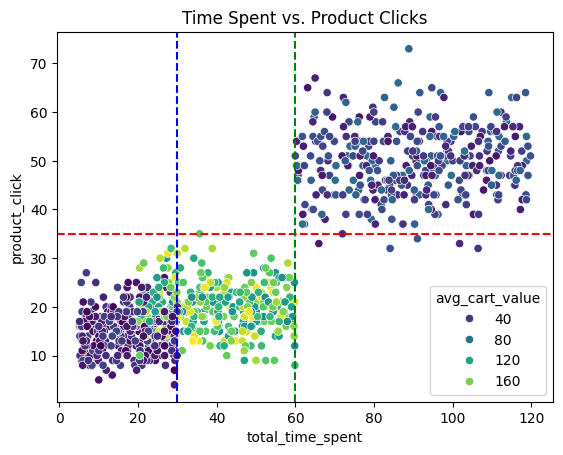

In [27]:
sns.scatterplot(data=df, x="total_time_spent", y="product_click", hue="avg_cart_value", palette="viridis")
plt.axhline(35, color='red', linestyle='--')
plt.axvline(60, color='green', linestyle='--')
plt.axvline(30, color='blue', linestyle='--')
plt.title("Time Spent vs. Product Clicks")
plt.show()

* Observation :

This visualization highlights the High Spenders as a distinct group with higher cart values but moderate interaction, while Bargain Hunters and Window Shoppers will have lower or similar cart values but differ in their browsing behavior.

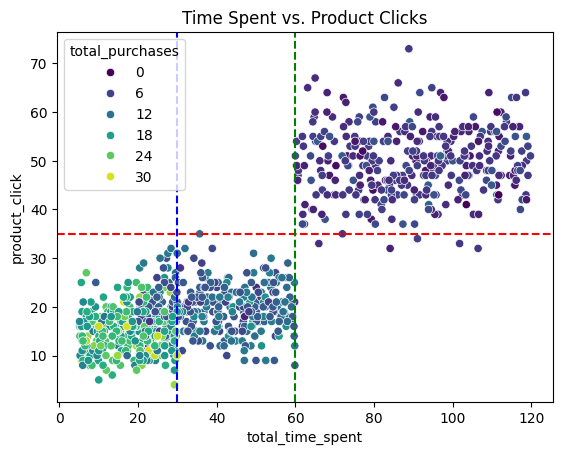

In [28]:
sns.scatterplot(data=df, x="total_time_spent", y="product_click", hue="total_purchases", palette="viridis")
plt.axhline(35, color='red', linestyle='--')
plt.axvline(60, color='green', linestyle='--')
plt.axvline(30, color='blue', linestyle='--')
plt.title("Time Spent vs. Product Clicks")
plt.show()

* Observation :

This plot can help confirm the clusters: Bargain Hunters are highlighted by their higher number of purchases, showing moderate browsing and product interaction, while High Spenders have a lower total purchases and moderate interaction. Window Shoppers are distinguished by high interaction but low purchase frequency.


#### Boxplot to show distribution of features

##### 1.   Average cart value across discount usage

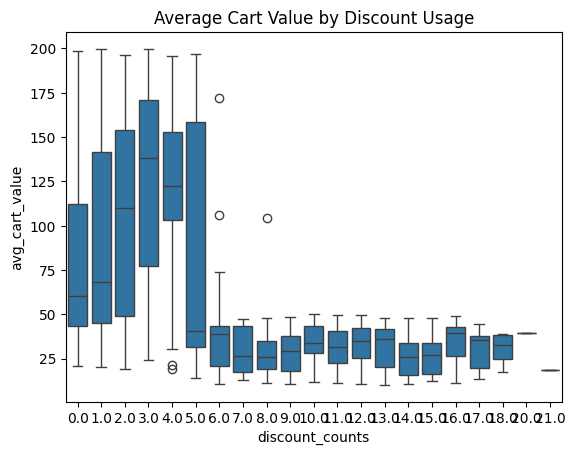

In [43]:
sns.boxplot(data=df, x="discount_counts", y="avg_cart_value")
plt.title("Average Cart Value by Discount Usage")
plt.show()

* This boxplot shows the distribution of average cart value based on discount usage, revealing how discounts influence average cart values.


* Observation :

It reveals a clear difference between Bargain Hunters and High Spenders, with the former having lower cart values when higher discounts are used and the latter maintaining higher cart values and using lower discounts.

### Dimensionality Reduction

In [45]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

#### UMap

In [47]:
reducer = umap.UMAP()

In [48]:
embedding = reducer.fit_transform(scaled_df)
embedding.shape

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(979, 2)

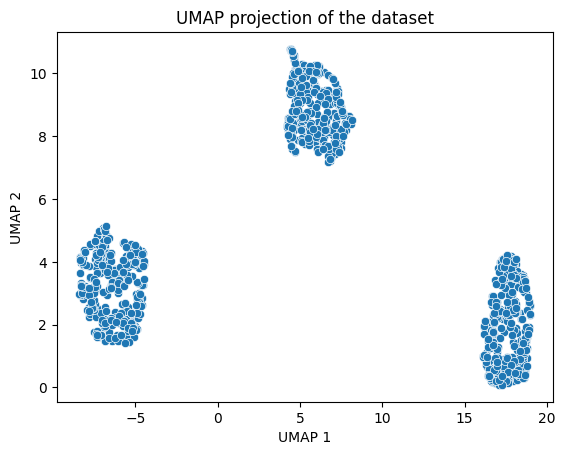

In [50]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1])
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP projection of the dataset')
plt.show()

* UMAP 2D plot reveals a clear separation of the distinct clusters.

##### Comparison with features

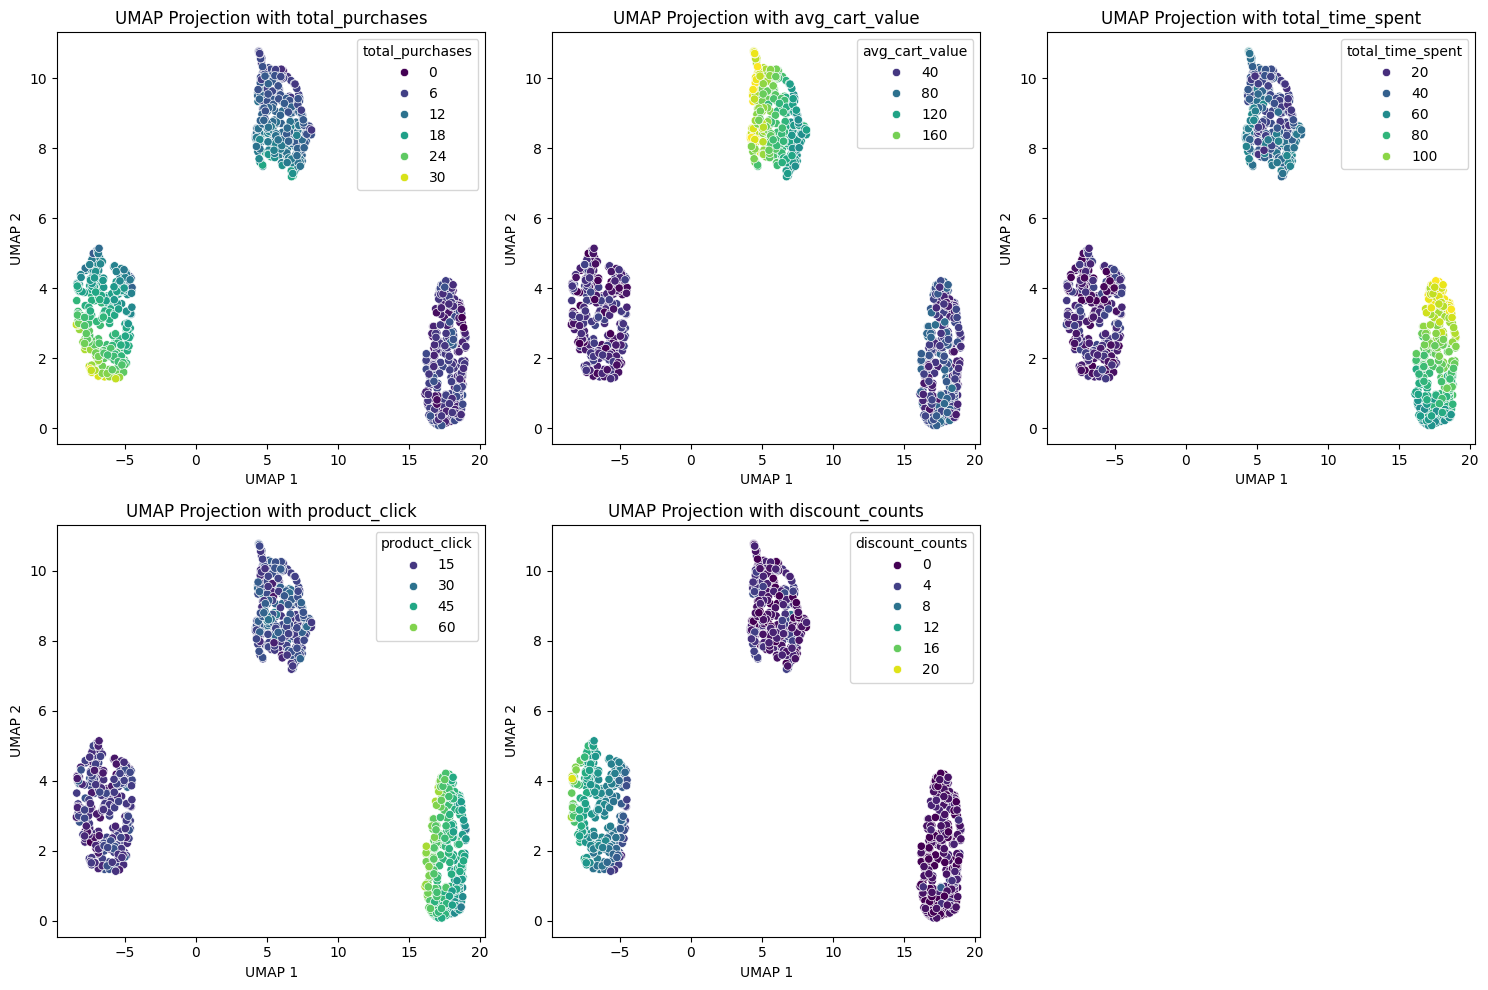

In [54]:
# Create a 2x3 grid for the plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop over the columns/features and plot them on respective axes
for i, feat in enumerate(df.columns):
    # Avoid IndexError if there are more than 5 features
    if i < 5:
        sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=df[feat], palette='viridis', ax=axes[i])
        axes[i].set_xlabel('UMAP 1')
        axes[i].set_ylabel('UMAP 2')
        axes[i].set_title(f'UMAP Projection with {feat}')

axes[i+1].axis('off')  # Turn off unused plots

# Adjust layout
fig.tight_layout()
plt.show()

#### PCA

In [77]:
# initializing PCA with 2 components so that the data can be reduced to 2 dimensions for plotting
pca = PCA(n_components=2)

In [78]:
# fitting PCA on normalized data
df_pca = pca.fit_transform(scaled_df)
df_pca = pd.DataFrame(data=df_pca, columns=['PC1','PC2'])

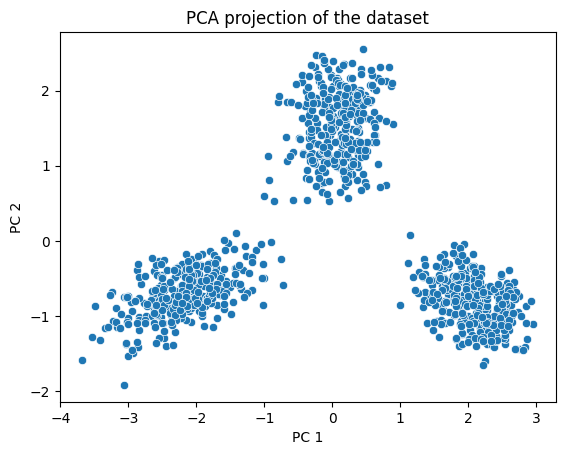

In [79]:
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA projection of the dataset')
plt.show()

* The 2D PCA projection of the dataset also showed a clear separation of three clusters, reinforcing the findings from UMAP.

In [36]:
task_2 = df.to_csv("task_02_preprocessed.csv", index=True)

## Data Standardization

In [38]:
df = pd.read_csv("task_02_preprocessed.csv", index_col=0)

In [45]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

## Creating Segmentation Models

* With the preprocessed data, let's start the model-building process.

* Before selecting a model, it was necessary to confirm that having three clusters was indeed the optimal choice for the number of clusters for this dataset.

### Finding the optimal number of clusters

In [46]:
# creating a function to calculate WCSS and Silhouette score
def compute_scores(data, k_range):

    # creating empty list to save scores
    wcss_scores = []
    silhouette_scores = []
    for k in k_range:

        # fitting KMeans model to the data
        kmeans = KMeans(n_clusters=k, random_state=123)
        kmeans.fit(data)

        # computing WCSS scores
        wcss_scores.append(kmeans.inertia_)

        # computing k-means labels and silhouette score
        kmeans_labels = kmeans.labels_
        if len(set(kmeans_labels)) > 1: # ensuring at least 2 clusters for silhouette score
            silhouette_scores.append(silhouette_score(data, kmeans_labels))
        else:
            silhouette_scores.append(0) # setting silhouette score to 0 if only 1 cluster

    # returning scores
    return wcss_scores, silhouette_scores

In [47]:
# creating a user defined function to find the elbow point in the Within-Cluster Sum of Squares (WCSS) scores
def find_elbow_point(wcss):

    # computing differences between consecutive WCSS scores
    differences = np.diff(wcss)

    # computing differences between consecutive differences
    second_differences = np.diff(differences)

    # finding the index of the first positive change in the second differences
    elbow_point_index = np.where(second_differences > 0)[0][0] + 1

    # returning the index
    return elbow_point_index

In [48]:
# setting the range for values of k in k-means
k_range = range(2, 11)

# computing WCSS and silhouette scores
wcss_scores, silhouette_scores = compute_scores(df, k_range)

# computing elbow point index
elbow_point_index = find_elbow_point(wcss_scores)

# finding the index of the maximum silhouette score
best_k_index = np.argmax(silhouette_scores)
best_k = k_range[best_k_index]

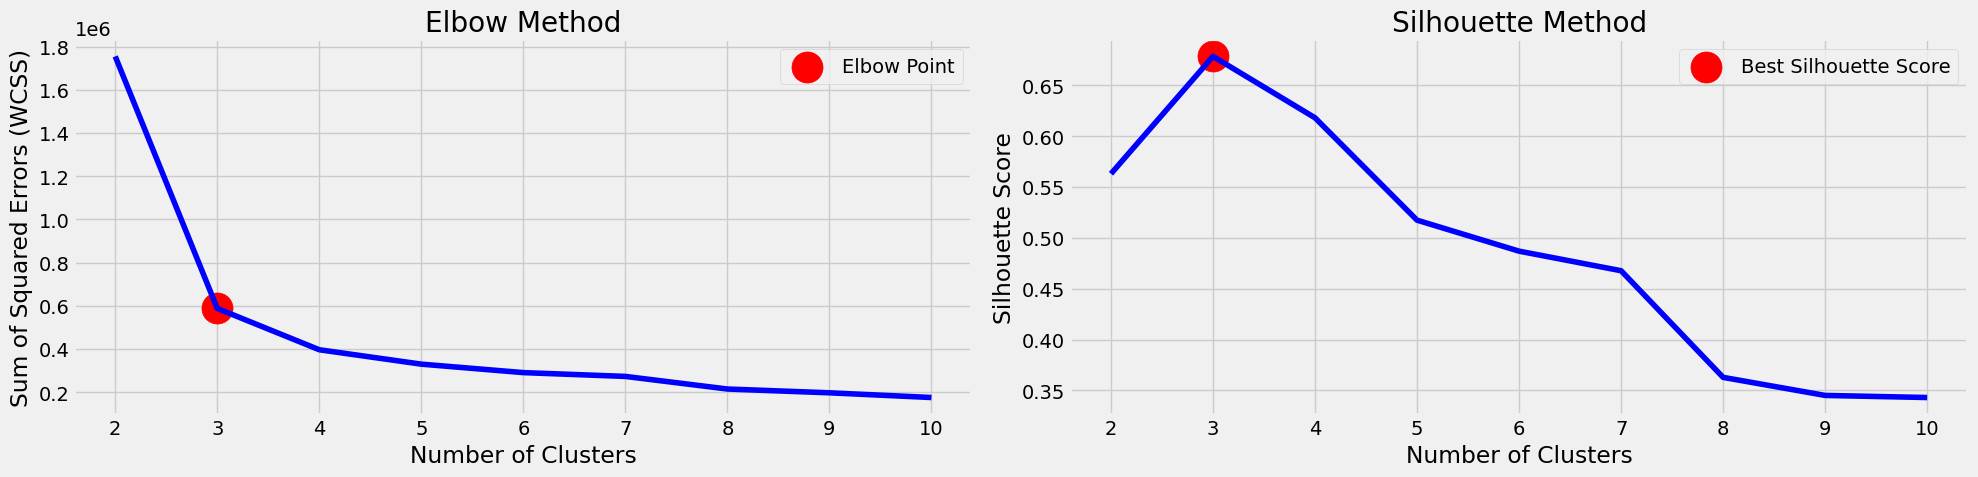

In [49]:
# setting style
plt.style.use("fivethirtyeight")

# creating subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# plotting inertia (WCSS) for Elbow plot
axes[0].plot(k_range, wcss_scores, color='blue')
axes[0].scatter(k_range[elbow_point_index], wcss_scores[elbow_point_index], color='red', marker='o', s=500, label='Elbow Point')
axes[0].set_title('Elbow Method')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Sum of Squared Errors (WCSS)')
axes[0].legend()

# plotting Silhouette Score
axes[1].plot(k_range, silhouette_scores, color='blue')
axes[1].scatter(best_k, silhouette_scores[best_k_index], color='red', marker='o', label='Best Silhouette Score', s=500)
axes[1].set_title('Silhouette Method')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Silhouette Score')
axes[1].legend()

# displaying plot
plt.tight_layout()
plt.show()

Here creates nine models with K values ranging from 2 to 10 and calculate the WCSS and Silhouette score for each cluster solution.

A noticeable "elbow" appeared at k=3, indicating diminishing returns in variance reduction beyond this point, also the highest Silhouette score is for K=3.

Let's print the silhouette scores for different cluster solutions .

In [50]:
# setting style back to default
plt.style.use("default")

# printing silhouette score for each cluster for better clarity
max_score = max(silhouette_scores)
max_index = silhouette_scores.index(max_score)
max_clusters = k_range[max_index]

for i, score in zip(k_range, silhouette_scores):
    print(f"Silhouette Score for {i} Clusters:", round(score, 4))

print(f"\n**Maximum Silhouette Score: {round(max_score, 4)} (achieved with {max_clusters} clusters)**")

Silhouette Score for 2 Clusters: 0.5629
Silhouette Score for 3 Clusters: 0.6782
Silhouette Score for 4 Clusters: 0.6179
Silhouette Score for 5 Clusters: 0.5173
Silhouette Score for 6 Clusters: 0.4869
Silhouette Score for 7 Clusters: 0.4677
Silhouette Score for 8 Clusters: 0.3629
Silhouette Score for 9 Clusters: 0.3451
Silhouette Score for 10 Clusters: 0.3431

**Maximum Silhouette Score: 0.6782 (achieved with 3 clusters)**


* The highest average silhouette score was observed at k=3, confirming that this choice results in well-separated and meaningful clusters.

### Model Selection

In [51]:
# Copying cleaned data
df_with_clusters = df.copy()

To determine the most suitable clustering model for customer segmentation, the following clustering algorithms were tested and compared.

1. K-Means Clustering
2. Agglomerative Clustering
3. DBSCAN
4. Gaussian Mixture Model (GMM)
5. Mean Shift Clustering
6. Spectral Clustering


In [52]:
# Running different clustering algorithms
models = {
    "K-Means (k=3)": KMeans(n_clusters=3, random_state=42),
    "Agglomerative (k=3)": AgglomerativeClustering(n_clusters=3),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5),
    "GMM" : GaussianMixture(n_components=3, random_state=42),
    "MeanShift" : MeanShift(),
    "SpectralClustering" : SpectralClustering(n_clusters=3, random_state=42)
}

In [53]:
# Dictionary to store cluster labels
cluster_results = {}

for name, model in models.items():
    # Fitting the model and predicting cluster labels
    if name == "DBSCAN":
        cluster_labels = model.fit_predict(scaled_df)
    else:
        cluster_labels = model.fit_predict(scaled_df)
        df_with_clusters[name] = cluster_labels

    cluster_results[name] = cluster_labels

In [54]:
# initializing PCA with 2 components so that the data can be reduced to 2 dimensions for plotting
pca_2 = PCA(n_components=2)

# fitting PCA on normalized data
df_pcs_2 = pca_2.fit_transform(scaled_df)
df_pcs_2 = pd.DataFrame(data=df_pcs_2, columns=['PC1','PC2'])

### Visualize Clusters

In [55]:
# Adding cluster labels for each model
for name, labels in cluster_results.items():
    df_pcs_2[name] = labels

<ipython-input-56-51ec94397a5b>:9: UserWarning: 
The palette list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=df_pcs, x='PC1', y='PC2', hue=cluster_labels, palette=custom_colors, alpha=0.6, ax=ax)


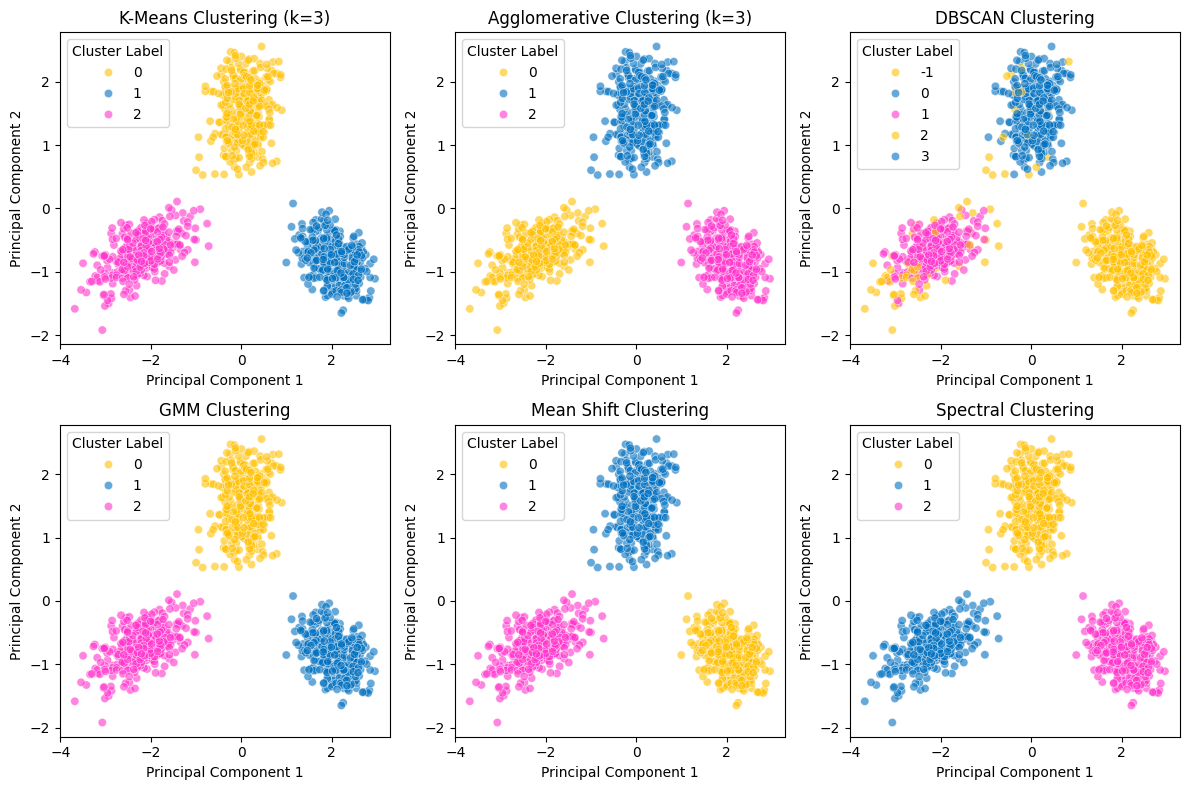

In [56]:
# Setting up subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Custom colors for clusters
custom_colors = ['#ffc000', '#0070c0', '#ff33cc']

# Function to plot clusters
def plot_clusters(ax, df_pcs, cluster_labels, title):
    sns.scatterplot(data=df_pcs, x='PC1', y='PC2', hue=cluster_labels, palette=custom_colors, alpha=0.6, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.legend(title="Cluster Label")

# Plot for K-Means
plot_clusters(axes[0, 0], df_pcs_2, df_pcs_2["K-Means (k=3)"], "K-Means Clustering (k=3)")

# Plot for Agglomerative Clustering
plot_clusters(axes[0,1], df_pcs_2, df_pcs_2["Agglomerative (k=3)"], "Agglomerative Clustering (k=3)")

# Plot for DBSCAN (Handles noise points)
plot_clusters(axes[0,2], df_pcs_2, df_pcs_2["DBSCAN"], "DBSCAN Clustering")

# Plot for GMM
plot_clusters(axes[1,0], df_pcs_2, df_pcs_2["GMM"], "GMM Clustering")

# Plot for MeanShift
plot_clusters(axes[1, 1], df_pcs_2, "MeanShift", "Mean Shift Clustering")

# Plot for SpectralClustering
plot_clusters(axes[1, 2], df_pcs_2, "SpectralClustering", "Spectral Clustering")

# Adjust layout
plt.tight_layout()
plt.show()

### Model Evaluation

* To assess the quality of clustering models, multiple evaluation metrics: Silhouette Score, Calinski-Harabasz Index and Density-Based Clustering Validation (DBCV) are utilized.

In [ ]:
pip install "git+https://github.com/FelSiq/DBCV"

In [74]:
import dbcv

In [73]:
# Dictionary to store evaluation scores
evaluation_scores = {
    "Model": [],
    "Silhouette Score": [],
    "Calinski-Harabasz Index": [],
    "DBCV Score": []
}

In [75]:
# Compute evaluation metrics for each clustering model
for name, cluster_labels in cluster_results.items():
    silhouette = silhouette_score(scaled_df, cluster_labels)
    calinski_harabasz = calinski_harabasz_score(scaled_df, cluster_labels)
    dbcv_score = dbcv.dbcv(scaled_df, cluster_labels)

    # Store results
    evaluation_scores["Model"].append(name)
    evaluation_scores["Silhouette Score"].append(silhouette)
    evaluation_scores["Calinski-Harabasz Index"].append(calinski_harabasz)
    evaluation_scores["DBCV Score"].append(dbcv_score)

In [76]:
# Create final DataFrame
evaluation_df = pd.DataFrame(evaluation_scores)

# Display results
print(evaluation_df)

                 Model  Silhouette Score  Calinski-Harabasz Index  DBCV Score
0        K-Means (k=3)          0.626018              2452.116045    0.494025
1  Agglomerative (k=3)          0.626018              2452.116045    0.494025
2               DBSCAN          0.365837               784.674716    0.394705
3                  GMM          0.626018              2452.116045    0.494025
4            MeanShift          0.626018              2452.116045    0.494025
5   SpectralClustering          0.626018              2452.116045    0.494025


* k-Means, Agglomerative Clustering, GMM, Mean Shift, and Spectral Clustering all achieved the same scores across three evaluation metrics, indicating similar performance in separating the clusters.

* DBSCAN had the lowest silhouette score (0.366), which is lower than that of K-Means, indicating weaker separation between clusters. Also it has the lowest DBCV Score (0.395), which implies DBSCAN has weaker clustering quality than the others.

* k-Means was chosen as the final model because of its efficiency, ease of interpretation, and well-defined cluster boundaries, as seen in the PCA and UMAP visualizations

## Analyzing Data for Different Clusters

#### Calculating Cluster Proportions

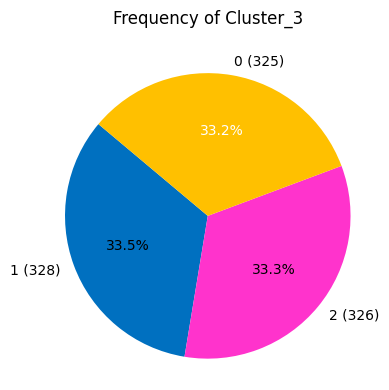

In [ ]:
# creating a function to plot a frequency pie chart
def plot_freq_pie_chart(df, column_name, pie_colors, font_colors, ax=None):

    # calculating the proportion and count of each category of the column
    value_counts = df[column_name].value_counts()
    proportion = value_counts / len(df)

    # plotting a pie chart with custom colors, bold text, and number of values in brackets
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    patches, texts, autotexts = ax.pie(
        proportion,
        labels=[f"{label} ({value})" for label, value in value_counts.items()],
        autopct='%1.1f%%',
        startangle=140,
        colors=[pie_colors.get(label, 'gray') for label in value_counts.index],
        # textprops={'fontweight': 'bold'}
    )

    # setting font color for each label
    for text, font_color in zip(autotexts, font_colors):
        text.set_color(font_color)

    # adding title and space between the title and plot
    ax.set_title(f'Frequency of {column_name}', fontsize=12, pad=20)

    # setting equal aspect ratio to ensure that pie is drawn as a circle
    ax.axis('equal')


# setting up subplot for a single pie chart (only Cluster_3)
fig, ax = plt.subplots(figsize=(4, 4))

# pie chart for 3-cluster solution
plot_freq_pie_chart(
    df_with_clusters, 'Cluster_3',
    pie_colors={0: '#ffc000', 1: '#0070c0', 2: '#ff33cc'},
    font_colors=['black', 'black', 'white'],
    ax=ax
)

# setting layout and showing plot
plt.tight_layout()
plt.show()

### Identifying Clusters

In [ ]:
# defining a function to generate bar plots for average numerical columns with class labels
def cluster_analysis_by_cols(df, cols_for_analysis, cluster_column, colors, suptitle):

    # calculating number of rows and columns for subplots

    # setting a fixed number of columns
    num_cols = 3

    # calculating number of rows based on the number of numerical columns and columns per row
    num_rows = (len(cols_for_analysis) + num_cols - 1) // num_cols

    # setting figure size
    plt.figure(figsize=(20, 5 * num_rows))

    # defining width for bars
    bar_width = 0.35

    # looping through numerical columns
    for i, column in enumerate(cols_for_analysis):

        # creating subplots
        plt.subplot(num_rows, num_cols, i + 1)

        # creating a bar plot for every numerical column
        for cluster, color in colors.items():

            # extracting cluster data
            cluster_data = df[df[cluster_column] == cluster]

            # creating values for the x axis
            x_values = np.array([cluster - bar_width / 4, cluster + bar_width / 4])

            # calculating the mean of numerical column by cluster label
            y_values = np.array([cluster_data[column].mean()] * 2)

            # creating bar plot with custom color
            plt.bar(x_values, y_values, color=color, width=bar_width / 2, label=f'Cluster {cluster}')

        # calculating overall mean of the numerical column
        overall_mean = df[column].mean()

        # plotting horizontal lines for overall mean and 20% above and below the mean
        plt.axhline(y=overall_mean, color='black', linestyle='-')
        plt.text(0.5, overall_mean, f'Overall Mean: {overall_mean:.2f}', color='black', fontsize=9, ha='center', va='bottom')

        # adding title and labels
        plt.title(column, fontweight='bold')
        plt.xlabel('Cluster')
        plt.ylabel(f'Mean {column}')
        plt.xticks(list(colors.keys()), list(colors.keys())) # Set x-axis labels to cluster values

    # adjusting layout with tighter layout and rect to leave space for suptitle
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # adding suptitle
    plt.suptitle(suptitle, fontsize=20, fontweight='bold')

    # viewing plot
    plt.show()

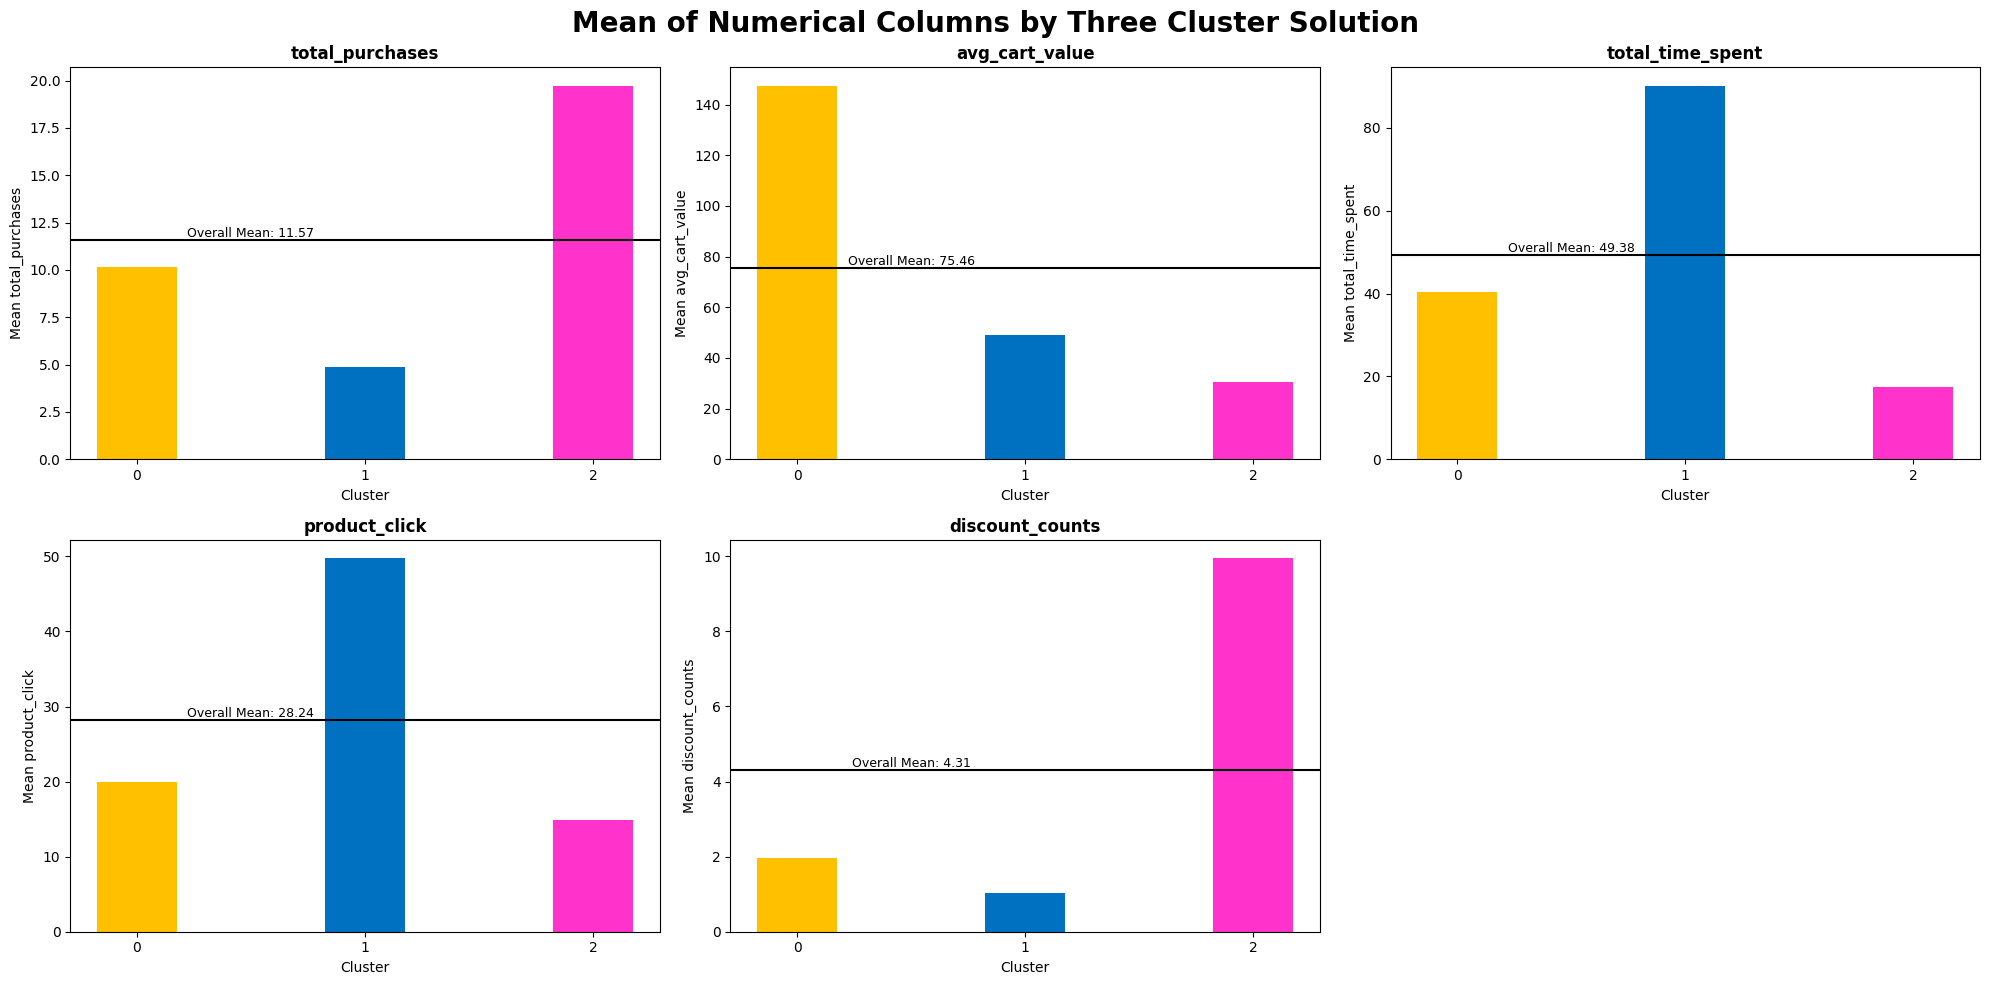

In [ ]:
# saving all columns that need to be analyzed
reqd_cols = df_with_clusters.columns[:-1]

# using function to create plots for the three cluster solution
cluster_analysis_by_cols(df = df_with_clusters, cols_for_analysis = reqd_cols, cluster_column = 'Cluster_3', colors = {0: '#ffc000', 1: '#0070c0', 2: '#ff33cc'}, suptitle = 'Mean of Numerical Columns by Three Cluster Solution')

**Key Observations**

- Total Purchases: Cluster 2 had the highest total purchases, whereas Cluster 1 had the lowest.
- Average Cart Value: Cluster 0 showed significantly higher cart values, indicating a preference for premium products.
- Total Time Spent: Cluster 0 spent more time on the platform compared to Cluster 2, but Cluster 1 exhibited the highest engagement level.
- Product Clicks: Cluster 1 had a higher product exploration tendency, while Cluster 0 and Cluster 2 had a moderate engagement.
- Discount Usage: Discount redemption was most frequent among Cluster 2 customers, highlighting their responsiveness to promotional offers.

**Based on the feature analysis, customer personas were assigned to each cluster.**

Cluster 0 : High Spenders

Cluster 1 : Window Shoppers

Cluster 2 : Bargain Hunters